In [1]:
import numpy as np
from scipy.linalg import lu_factor, lu_solve

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
sns.set(color_codes=True)

from tqdm import tqdm

In [2]:
from synthetic_datasets import *
from loss_models import *
from plot import *

# Try line of points along $\theta$

In [3]:
def sample_self_influence_line(X_orig, y_orig, z_new, v_range=[-5, 5], v_samples=50,
                               lm=LogisticRegression(),
                               row_types=["dataset", "loss", "hess_eig", "infl", "cosines"]):
    N, D = X_orig.shape
    s, w = np.ones(N + 1), np.zeros(N + 1)
    s[-1] = 0
    w[-1] = 1
    
    theta_s = lm.theta(X_orig, y_orig, np.ones(N))
    d_theta = theta_s / np.linalg.norm(theta_s)
    z_new[0] = z_new[0] / np.linalg.norm(z_new[0]) if z_new[0] is not None else d_theta
    
    # convention: capital V means plural
    V = np.linspace(v_range[0], v_range[1], v_samples)
    theta_swV = [lm.theta(np.vstack([X_orig, v * z_new[0]]),
                          np.hstack([y_orig, z_new[1]]), s + w) for v in V]
    
    # Losses
    l_swV = np.array([lm.L(v * z_new[0], z_new[1], 1, theta_swv) for (v, theta_swv) in zip(V, theta_swV)])
    l_sV = np.array([lm.L(v * z_new[0], z_new[1], 1, theta_s) for v in V])
    
    # Gradients, specialized for single point w.
    g_swV = np.array([lm.g(v * z_new[0], z_new[1], 1, theta_swv) for (v, theta_swv) in zip(V, theta_swV)])
    g_sV = np.array([lm.g(v * z_new[0], z_new[1], 1, theta_s) for v in V])
    
    # Gradients and norms, of test point
    gradl_swV = np.array([lm.g(v * z_new[0], z_new[1], 1, theta_swv) for (v, theta_swv) in zip(V, theta_swV)])
    gradl_sV = np.array([lm.g(v * z_new[0], z_new[1], 1, theta_s) for v in V])
    norm_gradl_swV = np.linalg.norm(gradl_swV, axis=1)
    norm_gradl_sV = np.linalg.norm(gradl_sV, axis=1)
    #r_T = np.dot(gradl_swV, gradl_s) / (norm_gradl_s ** 2.0)
    
    # Sanity check: gradients in the same direction?
    #crosses = np.array([np.cross(gradl_stw, gradl_s) for gradl_stw in gradl_swV])
    #assert(np.max(np.abs(crosses)) <= 1e-6)
    
    # Hessians
    H_swV_s = np.array([lm.H(X_orig, y_orig, (s + w)[:-1], theta_s) +
                        lm.H(v * z_new[0], z_new[1], (s + w)[-1], theta_s)
                        for v in V])
    H_s_swV = np.array([lm.H(X_orig, y_orig, s[:-1], theta_swv)
                        for theta_swv in theta_swV])
    H_swV_swV = np.array([lm.H(X_orig, y_orig, (s + w)[:-1], theta_swv) +
                          lm.H(v * z_new[0], z_new[1], (s + w)[-1], theta_swv)
                          for (v, theta_swv) in zip(V, theta_swV)])
    H_s_s = lm.H(X_orig, y_orig, s[:-1], theta_s)
    
    # Eigenvalues
    eig_swV_s = np.array([np.linalg.eigvalsh(H_swv_s) for H_swv_s in H_swV_s])
    eig_s_swV = np.array([np.linalg.eigvalsh(H_s_swv) for H_s_swv in H_s_swV])
    eig_swV_swV = np.array([np.linalg.eigvalsh(H_swv_swv) for H_swv_swv in H_swV_swV])
    eig_s_s = np.linalg.eigvalsh(H_s_s)
    
    # Directions
    costheta_swV = np.array([np.dot(theta_swv, d_theta) / np.linalg.norm(theta_swv)
                             for theta_swv in theta_swV])
    eigv_swV_swV = np.array([np.linalg.eig(H_swv_swv)[1] for H_swv_swv in H_swV_swV])
    costheta_eig1_swV = np.array([np.dot(eigv_swv_swv[:, 0], d_theta) for eigv_swv_swv in eigv_swV_swV])
    costheta_eig2_swV = np.array([np.dot(eigv_swv_swv[:, 1], d_theta) for eigv_swv_swv in eigv_swV_swV])
    
    # Hessian quadratic products
    #xHx_swV_swV_new = z_new[0].T.dot(H_swV_swV).dot(z_new[0])
    #xHx_swV_swV_test = z_test[0].T.dot(H_swV_swV).dot(z_test[0])
    
    # Test influence
    inv_prod = lambda a, H, b: a.dot(lu_solve(lu_factor(H), b))
    I_predV = np.array([-inv_prod(gradl_sv, H_s_s, g_sv) for (gradl_sv, g_sv) in zip(gradl_sV, g_sV)])
    I_actlV = l_swV - l_sV
    
    fig, axs = plt.subplots(len(row_types), 2, figsize=(16, 16 / 2 * len(row_types)))
    
    for ax_row, row_type in zip(axs, row_types):
        if row_type == "dataset":
            # Plot dataset and points
            annotations = [(z_new[0], z_new[1], '$z_{new}$')]
            plot_dataset(ax_row[0], X_orig, y_orig, annotations)
            plot_decision_boundary(axs[0][0], d_theta)
            plot_hessian(ax_row[0], H_s_s)

            # Plot loss
            plot_dataset(ax_row[1], X_orig, y_orig, annotations,
                         title='Loss',
                         grid_function=lambda x: lm.L(x, 1, 1, theta_s))
    
        elif row_type == "loss":
            # Plot test loss
            plot_lines(ax_row[0], V,
                       [(l_sV,  '$\\ell(v * z_{test}, \\theta(s))$'),
                        (l_swV, '$\\ell(v * z_{test}, \\theta(s + w))$')],
                       title='Loss of point should decrease')

            # Plot loss gradient norms
            plot_lines(ax_row[1], V,
                       [(norm_gradl_sV,  '$\\Vert \\nabla_\\theta(v * z_{test}, \\theta(s)) \\Vert$'),
                        (norm_gradl_swV, '$\\Vert \\nabla_\\theta(v * z_{test}, \\theta(s + w)) \\Vert$')],
                       title='Gradient of point should decrease')
    
        elif row_type == "hess_eig":
            # Using eigenvalues
            plot_lines(ax_row[0], V,
                       [(eig_s_s[0], '$\\lambda_1(H(s, \\theta(s)))$'),
                        (eig_swV_s[:, 0], '$\\lambda_1(H_v(s + w, \\theta(s)))$'),
                        (eig_s_swV[:, 0], '$\\lambda_1(H(s, \\theta_v(s + w)))$'),
                        (eig_swV_swV[:, 0], '$\\lambda_1(H_v(s + w, \\theta_v(s + w)))$'),
                       ],
                       title='Smaller eigenvalue should ???')
            plot_lines(ax_row[1], V,
                       [(eig_s_s[1], '$\\lambda_2(H(s, \\theta(s)))$'),
                        (eig_swV_s[:, 1], '$\\lambda_2(H_v(s + tw, \\theta(s)))$'),
                        (eig_s_swV[:, 1], '$\\lambda_2(H(s, \\theta_v(s + tw)))$'),
                        (eig_swV_swV[:, 1], '$\\lambda_2(H_v(s + tw, \\theta_v(s + tw)))$'),
                       ],
                       title='Larger eigenvalue should increase')
        
        elif row_type == "infl":
            # Plot influence, actual and predicted
            plot_lines(ax_row[0], V,
                       [(I_predV, '$-\\nabla_\\theta \ell(v * z_{test}, \\theta(s)) H^{-1}(s, \\theta(s)) g(w, \\theta(s))$'),
                        (I_actlV, '$\ell(v * z_{test}, \\theta(s+w)) - \ell(v * z_{test}, \\theta(s))$')],
                       title='Actual and predicted influence')
            
            plot_lines(ax_row[1], V,
                       [(I_actlV - I_predV, '$I_{actl} - I_{pred}$')],
                       title='Approximation error')
        
        elif row_type == "cosines":
            # Plot cosines of angles between vectors
            plot_lines(ax_row[0], V,
                       [(costheta_swV, '$\\hat\\theta(s)$')],
                       title='Cosine of angle between $\\theta_v(s+w)$ and others.')
            
            plot_lines(ax_row[1], V,
                       [(costheta_eig1_swV, '$\\nu_1(H(s+w, \\theta_v(s+w)))$')],
                       title='Cosine of angle between $\\theta_v(s+w)$ and others.')

In [4]:
N, D = 200, 2
X, y = generate_gaussian_mixture(N, D, separation=2, seed=0)

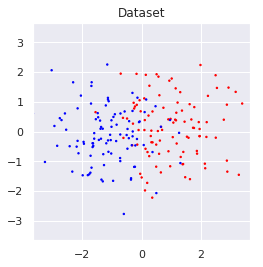

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_dataset(ax, X, y)

In [6]:
lm = LinearRegression()

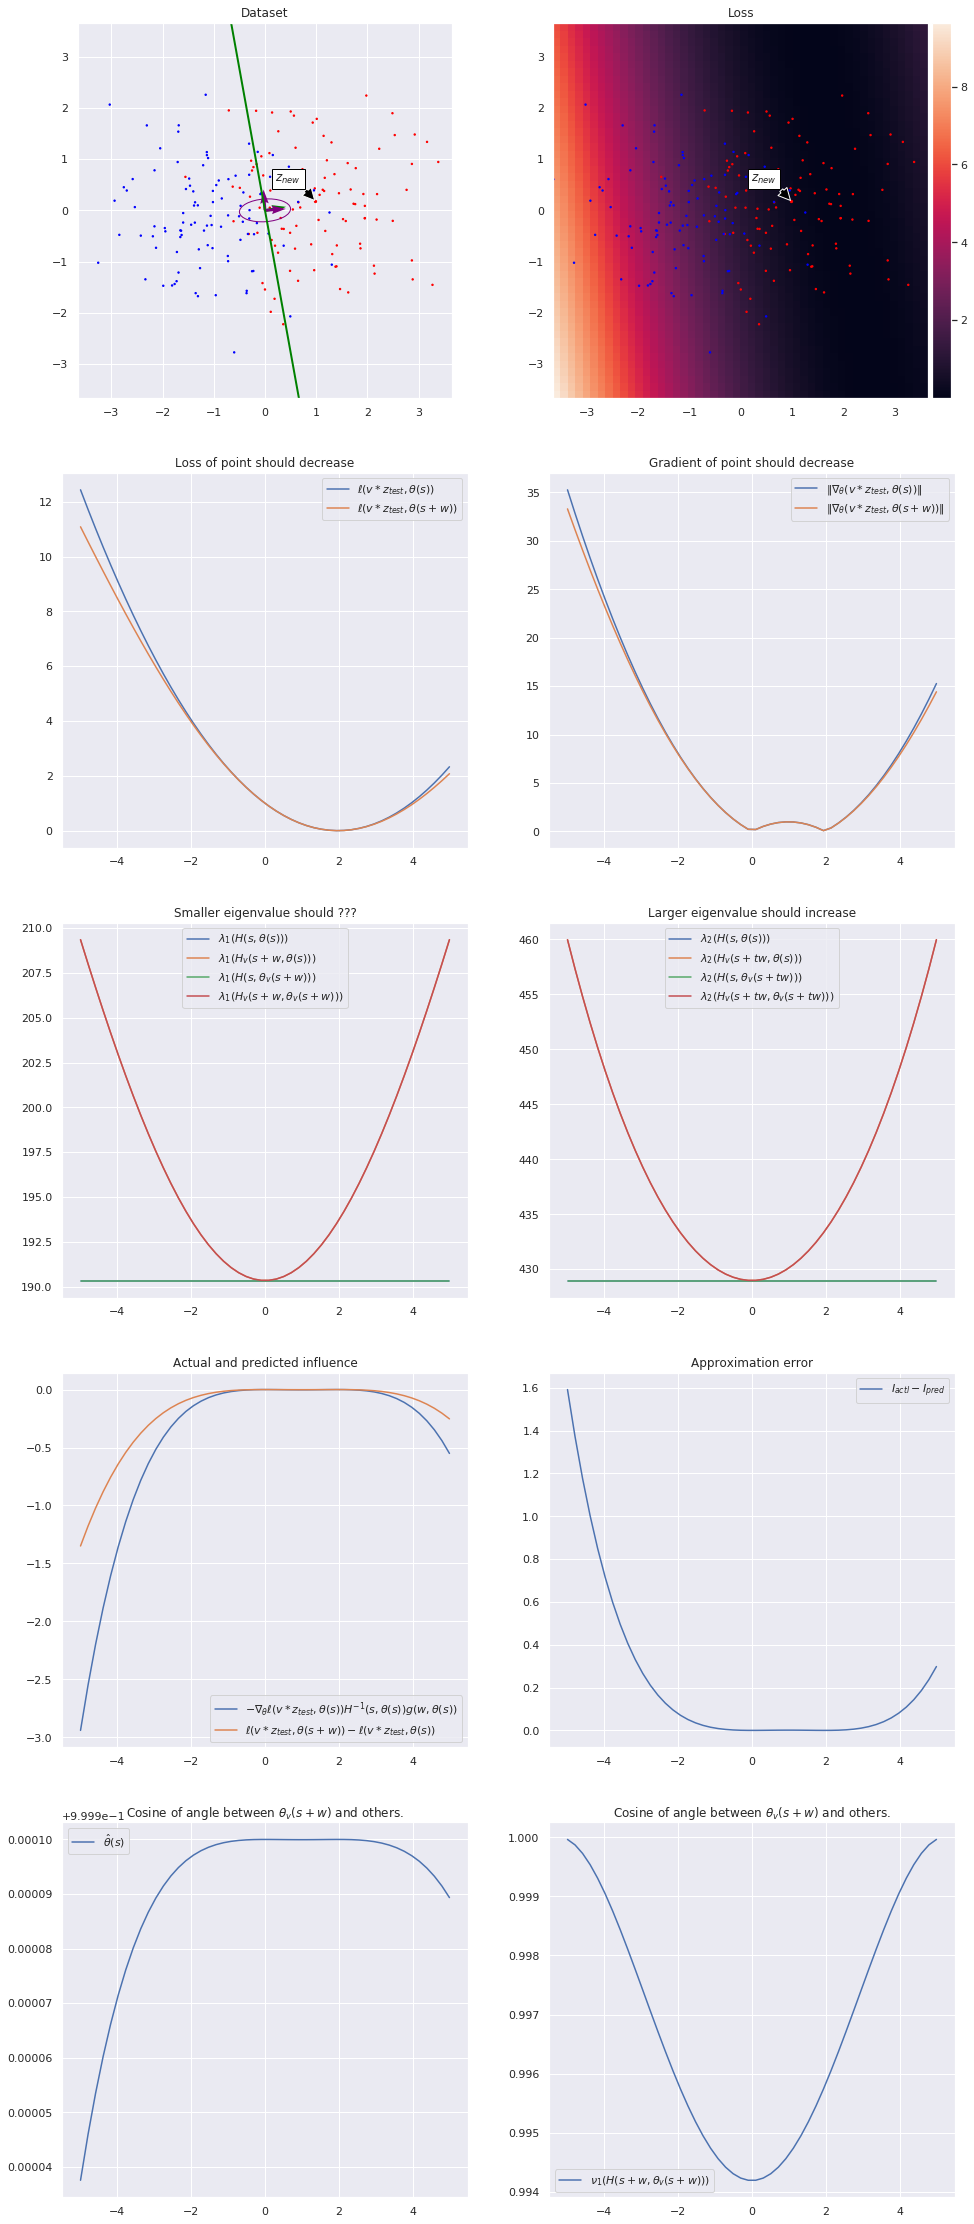

In [7]:
sample_self_influence_line(X, y, [None, 1], lm=lm)

# Bash for counterexamples

In [105]:
def find_counterexample(X_orig, y_orig, M=2, x_range=[-3, 3], lm=LogisticRegression(), iterations=10000):
    N, D = X_orig.shape
    
    theta_s = lm.theta(X_orig, y_orig, 1)
    H_s_s = lm.H(X_orig, y_orig, 1, theta_s)
    
    inv_prod = lambda a, H, b: a.dot(lu_solve(lu_factor(H), b))
    
    found = None
    I_preds, I_actuals = [], []
    for _ in xrange(iterations):
        X_add = np.random.uniform(x_range[0], x_range[1], (M, D))
        y_add = np.full(M, 1)
        
        X = np.vstack([X_orig, X_add])
        y = np.hstack([y_orig, y_add])
        theta_sw = lm.theta(X, y, 1)
        
        g_s = lm.g(X_add, y_add, 1, theta_s)
        l_s = lm.L(X_add, y_add, 1, theta_s)
        l_sw = lm.L(X_add, y_add, 1, theta_sw)
        
        I_pred = -inv_prod(g_s, H_s_s, g_s)
        I_actual = l_sw - l_s
        
        I_preds.append(I_pred)
        I_actuals.append(I_actual)
        
        if np.abs(I_actual) > np.abs(I_pred):
            found = X_add
            #break
    
    I_preds = np.array(I_preds)
    I_actuals = np.array(I_actuals)
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 24))
    annotations = []
    if found is not None:
        annotations = [(x_add, 1, '$x_{add}$') for x_add in found]
    plot_dataset(axs[0], X, y, annotations)
    
    V_max = max(np.max(I_preds), np.max(I_actuals)) + 0.5
    V_min = max(np.min(I_preds), np.min(I_actuals)) - 0.5
    
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    under = np.abs(I_actuals) > np.abs(I_preds)
    over = np.logical_not(under)
    print("{} underestimates in total.".format(np.sum(under)))
    axs[1].scatter(I_actuals[over], I_preds[over], marker='o', color='b', s=1)
    axs[1].scatter(I_actuals[under], I_preds[under], marker='x', color='r', s=10)
    axs[1].set_aspect('equal')
    axs[1].set_xlim([V_min, V_max])
    axs[1].set_ylim([V_min, V_max])
    axs[1].plot([V_min, V_max], [V_min, V_max], lw=1)
    axs[1].set_xlabel('Actual')
    axs[1].set_ylabel('Predicted')

In [99]:
N, D = 40, 2
X, y = generate_gaussian_mixture(N, D, separation=2, seed=0)

11 underestimates in total.


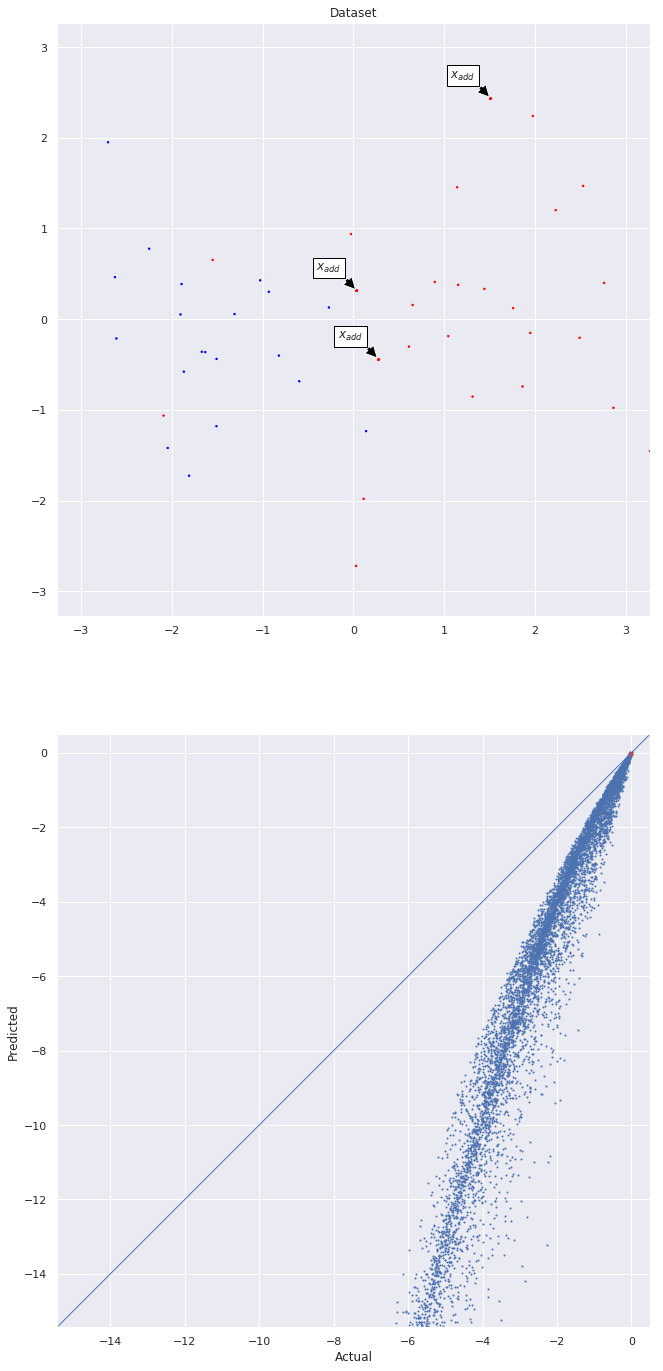

In [106]:
find_counterexample(X, y, M=3, lm=LogisticRegression())